## Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objs as go
import pickle

# handle warnings
import warnings
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)


from scipy.optimize import curve_fit

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from datetime import datetime
from dateutil.parser import parse

from fbprophet import Prophet

from pandas.plotting import lag_plot

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import mse, rmse
from statsmodels.tsa.statespace.varmax import VARMAX,VARMAXResults
from statsmodels.tsa.vector_ar.var_model import VAR

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from sklearn.preprocessing import StandardScaler





## Prepare Data

In [635]:
def prepare_data(date_file = r'Prediction_Study_4G_Sample.xlsx', Cell_4G = True):
    """ 
    Returns 1st step preprocessed tower data.

            Parameters:
                    data_file: file name of towers data to read
                    Cell_4G: boolean to check if 4G or 5G data to prepare

            Returns:
                    Towers_preprocessed: list of preprocessed towers
                    TARGET_VARIABLES: list of target variables
                    Towers_names: list of towers name
    """
    #read data
    data = pd.read_excel(date_file)
    df = pd.DataFrame(data)
    #columns with missing values (significant percentage missing )
    vars_with_na = [var for var in df.columns if df[var].isnull().sum()>1]
    Towers = []
    Towers_preprocessed = []
    
    if Cell_4G:
        # Variables missing in most of the towers
        vars_most_towers_na = ["VoLTE_Traffic_Erlang","CA_Data_Volume_DL_MB","Share_of_4G_RRC_connections_done_with_EN-DC_capable_EU"]
        
        #target variables
        TARGET_VARIABLES = ['Avg_User_Throughput_DL_Mbps',
                            'Avg_User_Throughput_UL_Mbps',
                            'PRB_Utilization_DL_BH',
                            'PRB_Utilization_UL_BH',
                            'Active_Cell_Throughput_DL_Mbps',
                            'Active_Cell_Throughput_UL_Mbps',
                            'Data_Volume_GB']

        df = df.drop('Site Name', axis = 1)
        df = df.set_index('Cell Names')


        for tower in (df.index.unique().tolist()):
            Towers.append(df.loc[tower])
        
        #preprocess each tower and append in list
        for tower in Towers:
            tower = tower.reset_index()
            tower = tower.set_index(["Day"]).sort_index()
            #drop cardinal & less relebant columns
            tower_preprocessed = tower.drop(['CELL_TYPE',
                                             'BANDWITH',
                                             'CELLID',
                                             'RRC_Connected_UE_MAX',
                                             'SR_Maximum_Active_UEs_with_Data_in_Buffer_per_Cell_DL',
                                             'SR_Maximum_Active_UEs_with_Data_in_Buffer_per_Cell_UL',
                                             'Cell_Availability%'] + vars_with_na + vars_most_towers_na , axis = 1)
            Towers_preprocessed.append(tower_preprocessed)

        Towers_names = df.index.unique().tolist()
        
    #5G   
    else:
        TARGET_VARIABLES = ['Avg_User_Thp_DL_Mbps',
                            'Avg_User_Thp_UL_Mbps',
                            'Cell_PRB_Utilzation_DL_BH',
                            'Cell_PRB_Utilzation_UL_BH',
                            'Active_Cell_Throughput_DL_Mbps',
                            'Active_Cell_Throughput_UL_Mbps',
                            'Data_Volume_GB']
        
        df = df.drop('Site Name', axis = 1)
        df = df.set_index('Cell Name')



        for tower in (df.index.unique().tolist()):
            Towers.append(df.loc[tower])

        for tower in Towers:
            tower = tower.reset_index()
            tower = tower.set_index(["Day"]).sort_index()
            tower_preprocessed = tower.drop(vars_with_na, axis = 1)
            Towers_preprocessed.append(tower_preprocessed)

        Towers_names = df.index.unique().tolist()
    
    return Towers_preprocessed, TARGET_VARIABLES, Towers_names


## 4G Data

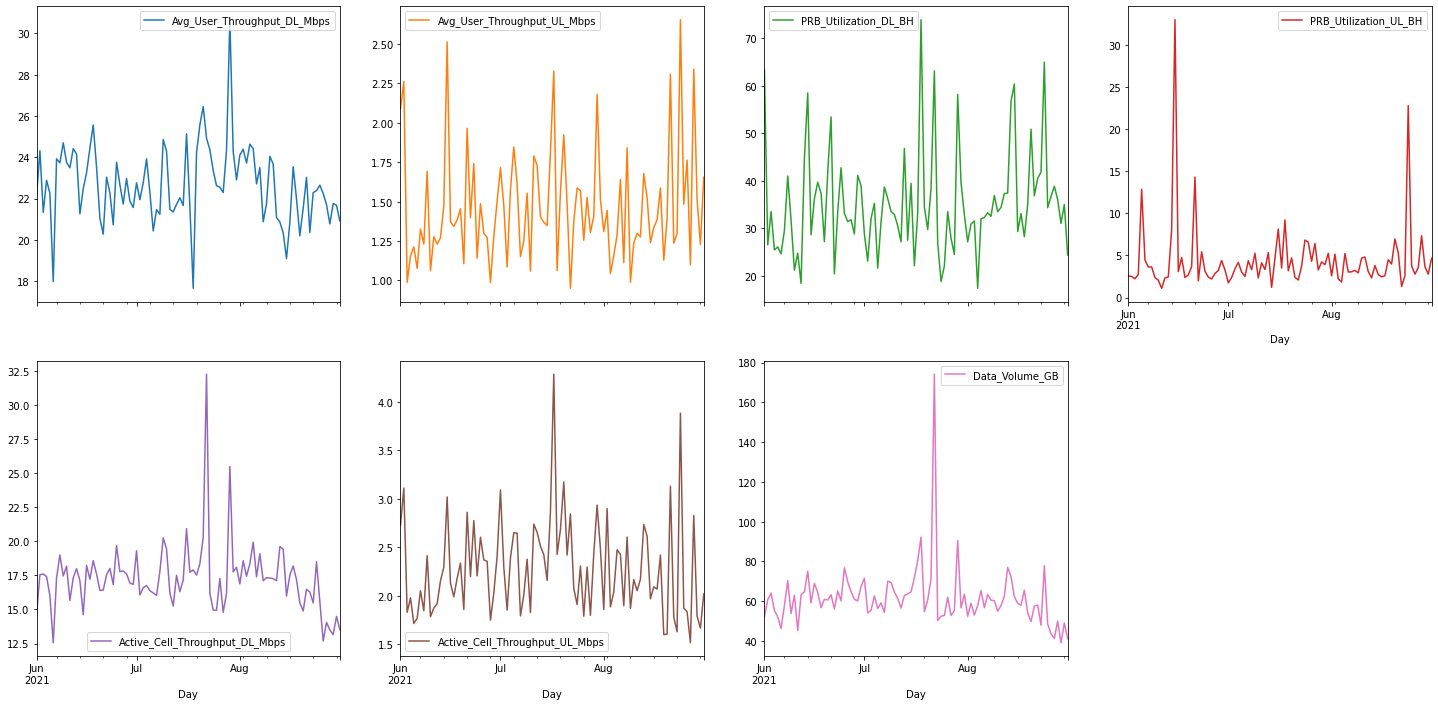

In [653]:
Towers_4G_preprocessed, TARGET_VARIABLES_4G, Towers_4G_names = prepare_data(date_file = r'Prediction_Study_4G_Sample.xlsx', Cell_4G = True)
Towers_4G_preprocessed[1][TARGET_VARIABLES_4G].plot(subplots=True,layout=(4,4), figsize=(25,25))

plt.show()


## 5G Data

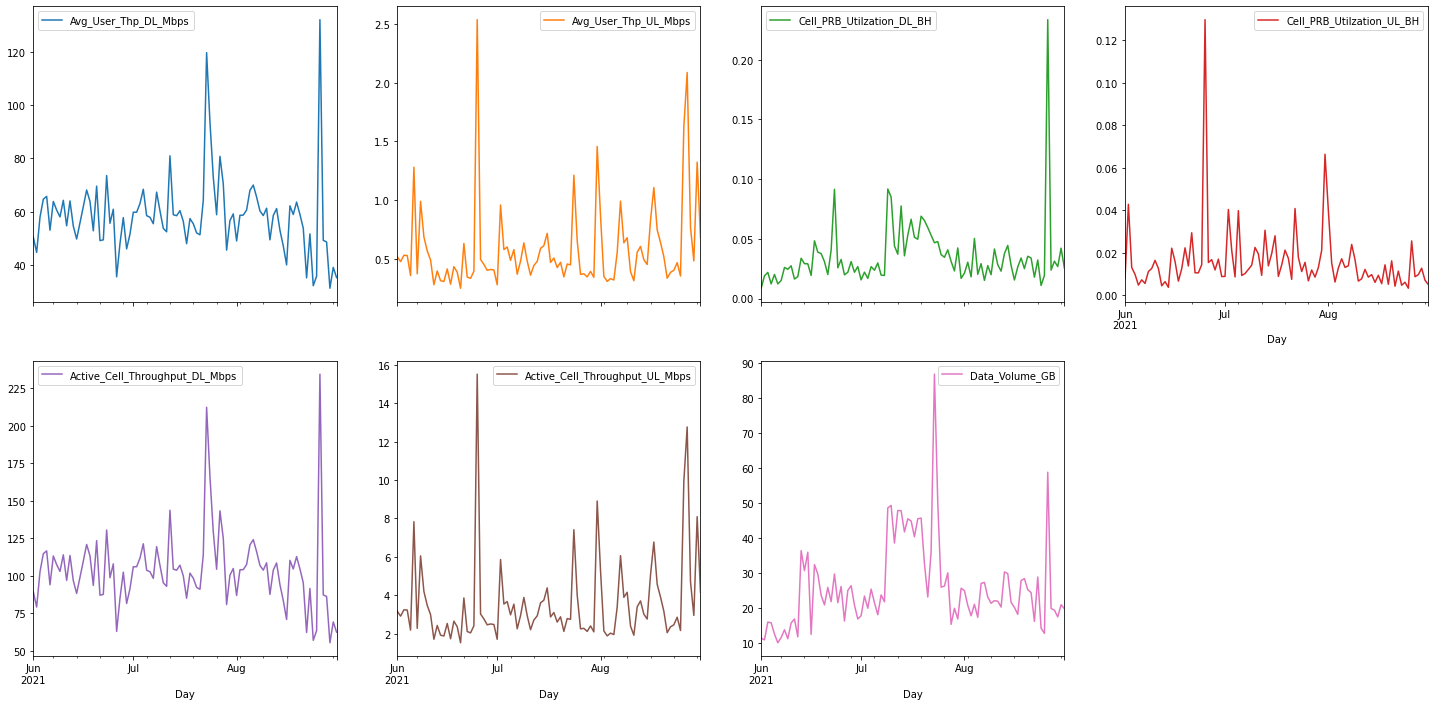

In [651]:
Towers_5G_preprocessed, TARGET_VARIABLES_5G, Towers_5G_names  = prepare_data(date_file = r'Prediction_Study_5G_Sample.xlsx', Cell_4G = False)

Towers_5G_preprocessed[0][TARGET_VARIABLES_5G].plot(subplots=True,layout=(4,4), figsize=(25,25))

plt.show()


## Helpers
### - Time-Series Decomposition
### - ACF&PCF
### - Lag Plots
### - Seasonality Plots
### - Augmented Dickey-Fuller Test for Stationarity
### - Plotting Prophet Forecasts
### - Plotting VARMAX Forecasts

In [629]:



# Decompose time-series to Trend + Seasonalty + Residual
def decompse_time_series(series):
    """ 
    Returns the trend, seasonal, and residual components of a time-series.

            Parameters:
                    series: a pandas series

            Returns:
                    trend, seasonal, resid
    """
    #decompose series
    result_add = seasonal_decompose(series, model='additive', extrapolate_trend='freq')
    plt.rcParams.update({'figure.figsize': (10,10)})
    result_add.plot()
    plt.show()
    return result_add.trend, result_add.seasonal,  result_add.resid




def plot_acf_pacf(series, lags):
    """ 
    plots auto-correlation function (acf) & partial acf of a time-series for a # of lags.

            Parameters:
                    series: a pandas series
                    lags: integer specifying the number of lags 

    """
    fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
    #plot ACF & PCF
    plot_acf(Series.tolist(), title = Series.name, lags=lags, ax=axes[0])
    plot_pacf(Series.tolist(),title = Series.name, lags=lags/2, ax=axes[1])
    

def plot_lag_plots(Series):
    """ 
    plots lag plots of a time-series.

            Parameters:
                    series: a pandas series

    """
    
    plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})
    fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
    for i, ax in enumerate(axes.flatten()[:4]):
        lag_plot(Series, lag=i+1, ax=ax)
        ax.set_title('Lag ' + str(i+1))

    fig.suptitle(f'Lag Plots of {Series.name} \n(Points get wide and scattered with increasing lag -> lesser correlation)\n', y=1.15)    




def Seasonality_plot(df, value):
    """ 
    plots the seasonality a time-series.

            Parameters:
                    df: a pandas dataframe
                    value: the column for which to plot seasonality

    """
    
    S = df.copy()
    S['Month'] = pd.DatetimeIndex(S.index).month
    S['Day'] = pd.DatetimeIndex(S.index).day
    # Stacked line plot
    plt.figure(figsize=(10,10))
    plt.title(f'Seasonality of the {value}')
    sns.pointplot(x='Day',y=val,hue='Month',data=S)

    
    
def stationarity_test(series):
    """ 
    prints Augmented Dickey-Fuller test statistic & p-value with rolling statistics plotted for a time-series.
    - More on ADF test : https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test

            Parameters:
                    series: a pandas series

    """
    # Get rolling statistics for window = 7 i.e. weekly statistics
    rolling_mean = series.rolling(window = 7).mean()
    rolling_std = series.rolling(window = 7).std()
    
    # Plot rolling statistic
    plt.figure(figsize= (10,6))
    plt.xlabel('Days')
    plt.ylabel(f'{series.name}')    
    plt.title(f'Stationary Test: Rolling Mean and Standard Deviation of {series.name}')
    plt.plot(series, color= 'blue', label= 'Original')
    plt.plot(rolling_mean, color= 'green', label= 'Rolling Mean')
    plt.plot(rolling_std, color= 'red', label= 'Rolling Std')   
    plt.legend()
    plt.show()
    
    # Dickey-Fuller test
    print('Results of Dickey-Fuller Test')
    df_test = adfuller(series,regression ='ctt', autolag='AIC')
    df_output = pd.Series(df_test[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in df_test[4].items():
        df_output['Critical Value (%s)' %key] = value
    print(df_output)    
    


def plot_forecast_prophet(future_df, validation_df, variable):
    """ 
    plots the actual, forecasted, upperbound, lowerbound for the prophet mode;.

            Parameters:
                    future_df: forecasted dataframe 
                    validation_df: validation dataframe 
                    variable: A target variable to plot

    """
    fig = go.Figure([
        go.Scatter(
            name='Forecast',
            x = validation_df['ds'],
            y = future_df['yhat'],#.loc[fut["ds"]>'2021-08-23']['yhat'],
            mode='lines',
            line=dict(color='rgb(31, 119, 180)'),
        ),
        go.Scatter(
            name='Actual',
            x = validation_df['ds'],
            y = validation_df['y'],
            mode='lines',
            line=dict(color='rgb(100, 0, 0)'),
        ),
        go.Scatter(
            name='Upper Bound',
            x=validation_df['ds'],
            y=future_df['yhat_upper'],#.loc[fut["ds"]>'2021-08-23']['yhat_upper'],
            mode='lines',
            marker=dict(color="#444"),
            line=dict(width=0),
            showlegend=False
        ),
        go.Scatter(
            name='Lower Bound',
            x=validation_df['ds'],
            y=future_df['yhat_lower'],#.loc[fut["ds"]>'2021-08-23']['yhat_lower'],
            marker=dict(color="#444"),
            line=dict(width=0),
            mode='lines',
            fillcolor='rgba(68, 68, 68, 0.3)',
            fill='tonexty',
            showlegend=False
        )
    ])

    fig.update_layout(
        yaxis_title= variable,
        xaxis_title= 'Day',
        title='Model Forecast Vs. Expected',
        hovermode="x"
    )

    fig.show()
    
    
def plot_forecast_VARMAX(Tower, Forecast_df, variable):

    """ 
    plots the actual and forecasted for the VARMAX model.

            Parameters:
                    Tower: validation dataframe 
                    Forecast_df: forecasted dataframe 
                    variable: A target variable to plot

    """
    fig = go.Figure([
    go.Scatter(
        name='Forecast',
        x = Tower.loc['2021-08-25':].index,
        y = Forecast_df.predicted_mean[variable],#['Avg_User_Throughput_DL_Mbps'],#.loc[fut["ds"]>'2021-08-23']['yhat'],
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    ),
    go.Scatter(
        name='Actual',
        x = Tower.loc['2021-08-25':].index,
        y = Tower.loc['2021-08-25':][variable],
        mode='lines',
        line=dict(color='rgb(100, 0, 0)'),
    )])

    fig.update_layout(
    yaxis_title= variable,
    xaxis_title= 'Day',
    title='Model Forecast Vs. Expected',
    hovermode="x"
    )

    fig.show()
    
def plot_all(RF, GB, Prophet_f, Varma_f, validation, var):

    """ 
    plots multiple forecasts  for each model.

            Parameters:
                    RF: Random Forest Forecast dataframe 
                    GB: Gradient Boosting Forecast dataframe 
                    Prophet_f: Prophet Forecast dataframe 
                    Varma_f: VARMAX Forecast dataframe 
                    validation: validation dataframe
                    var: a target variable to plot

    """
    fig = go.Figure([
    go.Scatter(
        name='RF_Forecast',
        x = validation.index,
        y = RF[var],
        mode='lines',
        line=dict(color='rgb(255,20,147)'),
    ),
    go.Scatter(
    name='GB_Forecast',
    x = validation.index,
    y = GB[var],
    mode='lines',
    line=dict(color='rgb(50, 0, 180)'),
    ),
    go.Scatter(
    name='Varma_Forecast',
    x = validation.index,
    y = Varma_f,
    mode='lines',
    line=dict(color='rgb(255, 156, 0)'),
    ), 
    go.Scatter(
    name='Prophet_Forecast',
    x = validation.index,
    y = Prophet_f,
    mode='lines',
    line=dict(color='rgb(0, 255, 0)'),
    ), 
        
    go.Scatter(
        name='Actual',
        x = validation.index,
        y = validation,
        mode='lines',
        line=dict(color='rgb(100, 0, 0)'),
    )])

    fig.update_layout(
    yaxis_title= var,
    xaxis_title= 'Day',
    title='Model Forecast Vs. Expected',
    hovermode="x"
    )

    fig.show()
    
    

def serialize_forecasts(model, model_fname,
                        forecasts, forecasts_fname,
                        valid = None, valid_fname = None):
    
    """ 
    serializes input data on disk.

            Parameters:
                    model: array of trained models
                    model_fname: file name to dump models into
                    forecasts: array of forecasted dataframes
                    forecasts_fname: file name to dump forecasts into
                    valid: array of validation data for each tower
                    valid_fname: file name to dump validation data into

    """
    with open(model_fname, "wb") as f:
        pickle.dump(RF_multiout_4G, f)

    with open(forecasts_fname, "wb") as f:
        pickle.dump(forecasts, f)
    if valid:
        with open(valid_fname, "wb") as f:
            pickle.dump(valid, f)

def plot_forecast(dates, actual, forecast, var):
    """ 
    plots multiple actual Vs. forecast for a target variable.

            Parameters:
                    dates: range of dates to plot across
                    actual: actual dataframe
                    forecast: forecasted dataframe
                    var: target variable to plot

    """
    fig = go.Figure([
    go.Scatter(
        name='Forecast',
        x = dates,
        y = forecast[var],
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    ),
    go.Scatter(
        name='Actual',
        x = dates,
        y = actual[var],
        mode='lines',
        line=dict(color='rgb(100, 0, 0)'),
    )])

    fig.update_layout(
    yaxis_title= var,
    xaxis_title= 'Day',
    title='Model Forecast Vs. Expected',
    hovermode="x"
    )

    fig.show()           

## Data Transformation & Feature Engineering

In [10]:

def create_supervised_ts(df,
                         roll_mean=7,
                         lags=4,
                         steps=7,
                         target_vars=None,
                         test_split_days=7,
                         non_stationary_vars= None):
    
    
    """ 
    Returns all engineered features names, scaler, train, and validation data.

            Parameters:
                    df: a pandas dataframe
                    roll_mean: window size to enginner roll_mean features
                    steps: # of future steps to frecast
                    target_vars: Target Variables
                    test_split_days: # days to split for validation
                    non_stationary_vars: list of non-stationary columns in df

            Returns:
                    train: preprossed training data
                    vald: preprocessed validation data
                    Scaler: Scaler used
                    lags_cols: list of lagged column names
                    forecasts_cols: list of forecasted column names(Target Variables, each with #steps)
                    
    """
    
    df = df.copy()
    cols = df.columns.tolist()
    
    # Get split day
    split_day = df.index[-1] - pd.to_timedelta(test_split_days, unit='d')
    Scaler = MinMaxScaler()    
    lags_cols = []
    forecasts_cols = []
    diffs = []
    means = []
    
    # Add Day-of-Week one-hot-encoded columns 
    date = pd.to_datetime(df.index).dayofweek
    encoded_days = pd.get_dummies(date, prefix='DOW')
    encoded_days.index = df.index
    df = pd.concat([df, encoded_days], axis=1)
    
    #Add Lags for each variable in the input dataframe, i.e, up to #lags past values 
    for var in cols:
        for lag in range(1,lags+1):
            lagged = f'{var}_lag_{lag}'
            lags_cols.append(lagged)
            df[lagged] = df[var].shift(lag)

    #if non_stationary_vars:
    
    #Perform and add differencing 1, 2 & 3 features to remove stationarity 
    for var in cols:
        #apply differencing->3 to remove trend and seasonality
        df[f'{var}_diff_1'] = df[var].diff()
        df[f'{var}_diff_2'] = df[var].diff().diff()
        df[f'{var}_diff_3'] = df[var].diff().diff().diff()
        rolling_mean = df[var].rolling(window = roll_mean).mean()
        df[f'{var}_roll_mean_{roll_mean}'] = rolling_mean
        means.append(f'{var}_roll_mean_{roll_mean}')
        
    


    train = df.loc[:split_day].copy()

    ##train[train.columns] = Scaler.fit_transform(train[train.columns]) #
    
    #Add #steps future columns for each target variable
    for var in target_vars:
        for step in range(1,steps+1):
            forecast = f'{var}_t+{step}'
            forecasts_cols.append(forecast)
            train[forecast] = train[var].shift(-step)

    #split validation data
    vald = df.loc[split_day:].iloc[1:].copy()
    
    ##vald[vald.columns] = Scaler.transform(vald[vald.columns]) 

    
    
    return train.dropna(), vald.dropna(), Scaler, lags_cols, forecasts_cols
    

    def split_data(train, valid, forecasts_cols, targets):
        
    """ 
    Returns training & validation features and targets.

            Parameters:
                    train: training dataframe
                    valid: validation dataframe
                    forecasts_cols: list of targets at future seps. i.e, variable(t+1), variable(t+2), ...
                    targets: target variables

            Returns:
                    x_train: training features
                    y_train: multi-step training targets
                    x_valid: validation features
                    y_valid: multi-step validation targets 
    """
        
        x_train = train[[col for col in train.columns if col not in forecasts_cols]]
        y_train  = train[[col for col in  forecasts_cols]]
        x_valid = valid.iloc[0:1,:]
        y_valid = valid.iloc[1:,:][targets]
        return x_train, y_train, x_valid, y_valid

## Random Forest & Gradient Boosting Regressors

In [623]:

def R_Forest_Reg(x_train, y_train, n_estimators, criterion='mse', max_depth=30, max_samples=None):
    
    """ 
    Returns a multi-output fitted random forest regressor, composing of multiple regressors for each target variable .

            Parameters:
                    x_train: training dataframe
                    y_train: training targets
                    n_estimators: # of estimators in the random forest regressor
                    criterion: loss criterion
                    max_depth: maximum depth for each base estimator
                    max_samples: the number of samples to draw from X to train each base estimator.

            Returns:
                   multi_out_regr: A fitted multi-output random rorest regressor
    """
        

    multi_out_regr = MultiOutputRegressor(RandomForestRegressor(n_estimators=n_estimators,
                                                                criterion=criterion,
                                                                max_depth=max_depth,
                                                                max_samples=max_samples,
                                                                random_state=0))

    multi_out_regr.fit(x_train, y_train )
    return multi_out_regr

def G_Boosting_Regressor(x_train, y_train, n_estimators, criterion='friedman_mse', max_depth=10):
        
    """ 
    Returns a multi-output fitted gradient boosting regressor, composing of multiple regressors for each target variable .

            Parameters:
                    x_train: training dataframe
                    y_train: training targets
                    n_estimators: # of estimators in the boosting regressor regressor
                    criterion: loss criterion
                    max_depth: maximum depth for each base estimator
                    max_samples: the number of samples to draw from X to train each base estimator.

            Returns:
                   multi_out_regr: A fitted multi-output gradient boosting regressor
    """
        
    
    multi_out_regr = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=n_estimators,
                                                                criterion=criterion,
                                                                max_depth=max_depth,
                                                                random_state=0,
                                                                min_samples_split=5,
                                                                   warm_start =True))
    multi_out_regr.fit(x_train, y_train )
    return multi_out_regr
    

    
        
def Validate_Model_New(model, x_valid, y_valid, show_plot = True):
    
            
    """ 
    Returns a dictionary containing 3 mertics values for all target variables & forecasts for the input model

            Parameters:
                    model: a tree-based mode (random forest/gradient boosting)
                    x_valid: input validation data
                    y_valid: targets validation data
                    show_plot: a boolean variable to enable plotting
            Returns:
                   metrics_dict: A dictionary containing MAE, RMSE & MAPE values for each target variable 
    """
    
    #Predict Forecasts Dataframe
    pred  = model.predict(x_valid)
    targets = y_valid.columns.tolist()
    pred = pred.reshape((len(targets),-1)).T
    pred_df = pd.DataFrame(pred)
    pred_df.columns = y_valid.columns 
    pred_df.index = y_valid.index
    dates = y_valid.index.tolist()
    
    
    metrics_dict ={}
    
    #Calculate Metrics for Target Variables
    for var in targets:
        MSE = mean_squared_error(y_valid[var], pred_df[var])
        RMSE = np.sqrt(MSE)
        MAE = mean_absolute_error(y_valid[var], pred_df[var])
        MABE = mean_absolute_percentage_error(y_valid[var], pred_df[var])
        metrics_dict[var] = {"RMSE":RMSE, "MAE": MAE, "MABE": MABE}
        
        #Plot Forecasted Vs. Actual
        if show_plot:
            plot_forecast(dates, y_valid, pred_df, var)
            
    return metrics_dict, pred_df


def validate_all_towers(Model, Towers_preprocessed, towers_names, var = 'Avg_User_Throughput_DL_Mbps' ):
    """ 
    Returns a dictionary containing MAE values for a specified target variable for all towers 
    & forecasts ofall towers for the input model

            Parameters:
                    model: a tree-based mode (random forest/gradient boosting)
                    Towers_preprocessed: All preprocessed towers data
                    towers_names: towers names
                    var: a target variable of interest
            Returns:
                   Validations: MAE value for predictions
                   Predictions: Forecasts of the model
    """
    Predictions = {}
    Validations = {}
    for tower_name in towers_names:
        dic, pred = Validate_Model_New(Model, Towers_preprocessed[tower_name]['X_valid'].reset_index().drop("Day", axis =1), Towers_preprocessed[tower_name]['Y_valid'], show_plot = False)
        Predictions[tower_name] = pred
        Validations[tower_name] = dic[var]['MAE']
    return Validations, Predictions



##  Transform & Merge All 4G & 5G Towers

In [493]:

def trans_to_sup_all_data(Towers_preprocessed, targets, Cell_4G = True):
    """ 
    Returns tranformed and merged data of all towers

            Parameters:
                    Towers_preprocessed: all preprocessed towers data
                    targets: target variables
                    Cell_4G: a boolean variable to indicate whether 4G or 5G towers
            Returns:
                   Towers_4G_Regression: all training and validation data
                   Merged_x_train: transformed & merged training data
                   Merged_y_train: merged training labels

                   
    """
    Towers_Regression = {}
    for tower in Towers_preprocessed:
        if Cell_4G:
            tower_name = tower["Cell Names"][0]
            df = tower.drop("Cell Names", axis = 1)
        else:
            tower_name = tower["Cell Name"][0]
            df = tower.drop("Cell Name", axis = 1)
            
        train, valid , scaler, lags, forecasts = create_supervised_ts(df = df,
                                                roll_mean = 7,
                                                lags = 7,
                                                steps = 7,
                                                test_split_days = 8,
                                                target_vars = targets,
                                                non_stationary_vars = targets)
        
        x_train, y_train, x_valid, y_valid = split_data(train, valid, forecasts, targets)
        Towers_Regression[tower_name] = {"X_train": x_train, "Y_train": y_train, "X_valid": x_valid, "Y_valid": y_valid}
    if Cell_4G:
        Merged_x_train = pd.DataFrame(columns = Towers_Regression["4GSite1A"]['X_train'].columns)
        Merged_y_train = pd.DataFrame(columns = Towers_Regression["4GSite1A"]['Y_train'].columns)
    else:
        Merged_x_train = pd.DataFrame(columns = Towers_Regression["5GSite1A"]['X_train'].columns)
        Merged_y_train = pd.DataFrame(columns = Towers_Regression["5GSite1A"]['Y_train'].columns)

    for tower_name in list(Towers_Regression.keys()):
        x_train = Towers_Regression[tower_name]['X_train'].reset_index().drop("Day", axis =1)
        y_train = Towers_Regression[tower_name]['Y_train'].reset_index().drop("Day", axis =1)

        Merged_x_train = Merged_x_train.append(x_train, ignore_index=True)
        Merged_y_train = Merged_y_train.append(y_train, ignore_index=True)
    return Towers_4G_Regression, Merged_x_train, Merged_y_train


Towers_4G_Regression, Merged_x_train_4G, Merged_y_train_4G = trans_to_sup_all_data(Towers_4G_preprocessed, TARGET_VARIABLES_4G, Cell_4G = True)


C:\ProgramData\Anaconda3\envs\Nokia\lib\site-packages\ipykernel_launcher.py:28: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

C:\ProgramData\Anaconda3\envs\Nokia\lib\site-packages\ipykernel_launcher.py:33: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

C:\ProgramData\Anaconda3\envs\Nokia\lib\site-packages\ipykernel_launcher.py:34: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat

## Train Random Forest & GBoosting on All 4G Towers 

In [16]:
RF_multiout_4G = R_Forest_Reg(Merged_x_train_4G, Merged_y_train_4G, n_estimators=20, criterion='squared_error', max_depth=20, max_samples=None)
GB_multiout_4G = G_Boosting_Regressor(Merged_x_train_4G, Merged_y_train_4G, n_estimators=20, criterion='friedman_mse', max_depth=20)

In [624]:
dic, pred_4G_RF = Validate_Model_New(RF_multiout_4G, Towers_4G_Regression["4GSite1B"]['X_valid'].reset_index().drop("Day", axis =1), Towers_4G_Regression["4GSite1B"]['Y_valid'], show_plot = True)


In [480]:

Validations_4G_RF, Predictions_4G_RF  = validate_all_towers(RF_multiout_4G, Towers_4G_Regression, Towers_4G_names, var = 'Avg_User_Throughput_DL_Mbps' )
Validations_4G_GB, Predictions_4G_GB  = validate_all_towers(GB_multiout_4G, Towers_4G_Regression, Towers_4G_names, var = 'Avg_User_Throughput_DL_Mbps' )


In [482]:
serialize_forecasts(RF_multiout_4G,"model_4G_RF.dat",
                   Predictions_4G_RF,"forecasts_4G_RF.dat",
                   Validations_4G_RF,"validation_4G_RF.dat" )

serialize_forecasts(GB_multiout_4G,"model_4G_GB.dat",
                   Predictions_4G_RF,"forecasts_4G_GB.dat",
                   Validations_4G_RF,"validation_4G_GB.dat" )

In [501]:
#Tower 1A - RF
_ = Validate_Model_New(RF_multiout_4G, Towers_4G_Regression["4GSite1A"]['X_valid'].reset_index().drop("Day", axis =1), Towers_4G_Regression["4GSite1A"]['Y_valid'], show_plot = True)

In [502]:
#Tower 1A - GB
_ = Validate_Model_New(GB_multiout_4G, Towers_4G_Regression["4GSite1A"]['X_valid'].reset_index().drop("Day", axis =1), Towers_4G_Regression["4GSite1A"]['Y_valid'], show_plot = True)

In [508]:

def all_towers_metrics(model, Towers_preprocessed, towers_names):
        
    """ 
    Returns a dictionary containing MAE values for all arget variable for all towers 
    & forecasts ofall towers for the input model

            Parameters:
                    model: a tree-based mode (random forest/gradient boosting)
                    Towers_preprocessed: All preprocessed towers data
                    towers_names: towers names
                   
            Returns:
                   Metrics_dict:  A dictionary containing MAE, RMSE & MAPE values for each target variable for all towers
                   Predictions: Forecasts of the model
    """
    Metrics_dict = {}
    for tower_name in towers_names:
        dic,_ = Validate_Model_New(model, Towers_preprocessed[tower_name]['X_valid'].reset_index().drop("Day", axis =1), Towers_preprocessed[tower_name]['Y_valid'], show_plot = False)
        Metrics_dict[tower_name] = dic
        
    return Metrics_dict

def average_all_towers_metrics(metrics_dic, targets, towers_names):
    
    """ 
    Returns a dictionary containing average MAE, RMSE & MAPE values for all target variable across all towers
    & forecasts ofall towers for the input model

            Parameters:
                    metrics_dic: A dictionary containing MSE, RMSE & MAPE values for each target variable
                    targets: All target variables
                    towers_names: towers names
                   
            Returns:
                   Average_Metrics_ALL_CELLS: averaged metrics values for all targets across all towers
    """
    Average_Metrics_ALL_CELLS = {}
    for var in targets:
        Root_MSE = 0
        Mean_AE = 0
        Mean_APE = 0
        for tower_name in towers_names:
            Root_MSE = Root_MSE + metrics_dic[tower_name][var]["RMSE"]
            Mean_AE = Mean_AE + metrics_dic[tower_name][var]["MAE"]
            Mean_APE = Mean_APE + metrics_dic[tower_name][var]["MABE"]
        Average_Metrics_ALL_CELLS[var] = {
            "Average_RMSE" : Root_MSE/len(Towers_4G_names),
            "Average_MAE" : Mean_AE/len(Towers_4G_names),
            "Average_APE" : Mean_APE/len(Towers_4G_names),
        }
    return Average_Metrics_ALL_CELLS

        
    


    
Metrics_RF_4G = all_towers_metrics(RF_multiout_4G, Towers_4G_Regression, Towers_4G_names)
Metrics_GB_4G = all_towers_metrics(GB_multiout_4G, Towers_4G_Regression, Towers_4G_names)

Average_RF_4G_all = average_all_towers_metrics(Metrics_RF_4G, TARGET_VARIABLES_4G, Towers_4G_names)
Average_GB_4G_all = average_all_towers_metrics(Metrics_GB_4G, TARGET_VARIABLES_4G, Towers_4G_names)


## Train Random Forest & GBoosting on All 5G Towers 

In [74]:
#Prepare Tranformed Supervised 5G data
Towers_5G_Regression, Merged_x_train_5G, Merged_y_train_5G = trans_to_sup_all_data(Towers_5G_preprocessed, TARGET_VARIABLES_5G, Cell_4G = False)

#Training
RF_multiout_5G = R_Forest_Reg(Merged_x_train_5G, Merged_y_train_5G, n_estimators=20, criterion='squared_error', max_depth=20, max_samples=None)
GB_multiout_5G = G_Boosting_Regressor(Merged_x_train_5G, Merged_y_train_5G, n_estimators=20, criterion='friedman_mse', max_depth=20)

In [497]:

#Validation of DL-throughput
Validations_5G_RF, Predictions_5G_RF  = validate_all_towers(RF_multiout_5G, Towers_5G_Regression, Towers_5G_names, var = 'Avg_User_Thp_DL_Mbps' )
Validations_5G_GB, Predictions_5G_GB  = validate_all_towers(GB_multiout_5G, Towers_5G_Regression, Towers_5G_names, var = 'Avg_User_Thp_DL_Mbps' )

serialize_forecasts(RF_multiout_5G,"model_5G_RF.dat",
                   Predictions_5G_RF,"forecasts_5G_RF.dat",
                   Validations_5G_RF,"validation_G_RF.dat" )

serialize_forecasts(GB_multiout_5G,"model_5G_GB.dat",
                   Predictions_5G_GB,"forecasts_5G_GB.dat",
                   Validations_5G_GB,"validation_5G_GB.dat" )


In [509]:
# Validate 4GSite1A

_ = Validate_Model_New(RF_multiout_5G, Towers_5G_Regression["5GSite1A"]['X_valid'].reset_index().drop("Day", axis =1), Towers_5G_Regression["5GSite1A"]['Y_valid'], show_plot = True)



In [510]:
# Validate 4GSite1B 

_ = Validate_Model_New(GB_multiout_5G, Towers_5G_Regression["5GSite1B"]['X_valid'].reset_index().drop("Day", axis =1), Towers_5G_Regression["5GSite1B"]['Y_valid'], show_plot = True)


In [512]:
Metrics_RF_5G = all_towers_metrics(RF_multiout_5G, Towers_5G_Regression, Towers_5G_names)
Metrics_GB_5G = all_towers_metrics(GB_multiout_5G, Towers_5G_Regression, Towers_5G_names)

Average_RF_5G_all = average_all_towers_metrics(Metrics_RF_5G, TARGET_VARIABLES_5G, Towers_5G_names)
Average_GB_5G_all = average_all_towers_metrics(Metrics_GB_5G, TARGET_VARIABLES_5G, Towers_5G_names)



0.563606719047619

In [630]:
dic = Validate_Model_New(GB_multiout_5G, Towers_5G_Regression["5GSite2A"]['X_valid'].reset_index().drop("Day", axis =1), Towers_5G_Regression["5GSite2A"]['Y_valid'], show_plot = True)


## FbProphet

## Fit Univariate Regressors for Each Variable

In [532]:
def forecast_uni_variates(df,
                          periods=8,
                          split_date='2021-08-24',
                          growth='linear',
                          interval_width=0.95,
                          weekly_seasonality=True,
                          daily_seasonality=False,
                          yearly_seasonality=False):
    
    
    
    """ 
    Returns a dataframe containing all uni-variate forecasts for a specified future interval.

            Parameters:
                    df: a pandas dataframe
                    periods: # of future steps(in days) for forecasting
                    split_date: date to split data
                    growth: type of trend to fit the forecasting  prophet model
                    interval_width5: confidence interval
                    weekly_seasonality: a boolean variable to accomodate for weekly seasonlity in training
                    daily_seasonality: a boolean variable to accomodate for daily seasonlity in training
                    yearly_seasonality: a boolean variable to accomodate for yearly seasonlity in training
            Returns:
                    forecast_df: dataframe containing all uni-variate forecasts
                    
    """
    
    regressors = [] # list of uni-variate regressors for prophet 
    forecast_df = pd.DataFrame()
    uni_variate_vars = [var for var in df.columns] #if var not in TARGET_VARIABLES]
    forecast_df['ds'] = df.loc[df.index>split_date].reset_index()['Day']
    df = df.copy()
    df = df.reset_index()
    
    #fit uni-variate prophet model for each variable in the data 
    for var in uni_variate_vars:
        uni_variate_model = Prophet(growth=growth,
                                    interval_width=interval_width,
                                    weekly_seasonality =weekly_seasonality,
                                    daily_seasonality=daily_seasonality,
                                    yearly_seasonality=yearly_seasonality)
        
        univariate_df = df.rename(columns={'Day':'ds', var : 'y'})
        train_df = univariate_df.loc[univariate_df["ds"]<=split_date]
        uni_variate_model.fit(train_df)
        #make forecasts
        forecasts = uni_variate_model.make_future_dataframe(periods=periods)
        forecasts = forecasts[forecasts['ds']>split_date]
        fut_vals = uni_variate_model.predict(forecasts.dropna(axis =0))
        forecast_df[var] = fut_vals['yhat']
    
    return forecast_df
  



## Multivariate Forecasting of Target Variables

### 4G- 1  Tower Example

In [116]:
Tower_data_mv = Towers_4G_preprocessed[0].drop("Cell Names",axis =1 ).reset_index()


train = lambda var, df, split_date: df.loc[df["Day"]<=split_date].rename(columns={'Day': 'ds', var: 'y'})
valid = lambda var, df, split_date : df.loc[df["Day"]>split_date].rename(columns={'Day': 'ds',var: 'y'})

Forecasts_prophet_1B = {}
for target in TARGET_VARIABLES_4G:
    reg = Prophet(growth='linear',interval_width=0.95, weekly_seasonality =True, daily_seasonality=False, yearly_seasonality=False)

    train_data = train(target, Tower_data_mv, '2021-08-24')
    valid_data = valid(target, Tower_data_mv, '2021-08-24')
    regress_vars = [var for var in train_data.columns if var not in ['ds','y']]

    for var in regress_vars:
        reg.add_regressor(var, standardize=False)

    reg.fit(train_data)    
    forecasts = reg.make_future_dataframe(periods=8)
    #forecasts = forecasts.iloc[-8:]
    #forecasts[regress_vars] = uni_forecast[regress_vars]

    fut = reg.predict(uni_forecast_1B.drop(target,axis=1))
    Forecasts_prophet_1B[target] = fut
    plot_forecast_prophet(fut, valid_data, target)
    

### Fbprophet All 4G Towers Training - Avg_User_Throughput_DL_Mbps


In [537]:

def FBprophet_training(Towers_preprocessed, Cell_4G = True):
    """ 
    Returns a list of fitted prophet models, univariate forecasts, validation data, and forecasts for each tower.

            Parameters:
                    Towers_preprocessed: list of all towers data
                    Cell_4G: a boolean variable to specifiy whether 4G or 5G data is used
                    
            Returns:
                    MODELS_ALL: list of all models for all towers
                    VALID_ALL: list of validation data for all towers
                    FUT_ALL: list of all target variables forecasts
                    UNI_FORECAST_ALL: list of all univariate forecasts used in forecasting targets
                    
    """
    train = lambda var, df, split_date: df.loc[df["Day"]<=split_date].rename(columns={'Day': 'ds', var: 'y'})
    valid = lambda var, df, split_date : df.loc[df["Day"]>split_date].rename(columns={'Day': 'ds',var: 'y'})

    VALID_ALL = []
    MODELS_ALL =[]
    UNI_FORECAST_ALL = []
    FUT_ALL = []

    for tower in Towers_4G_preprocessed:
        
        #check Towers type
        if Cell_4G:
            cell_name = tower["Cell Names"][0]
            tower = tower.drop("Cell Names", axis = 1)
            Targets = ['Avg_User_Throughput_DL_Mbps']
        else:
            cell_name = tower["Cell Name"][0]
            tower = tower.drop("Cell Name", axis = 1)
            Targets = ['Avg_User_Thp_DL_Mbps']

        #create univariate forecasts for all towers
        uni_forecast = forecast_uni_variates(df = tower,
                              periods=8,
                              split_date='2021-08-23',
                              growth='linear',
                              interval_width=0.95,
                              weekly_seasonality=True,
                              daily_seasonality=False,
                              yearly_seasonality=False)

        UNI_FORECAST_ALL.append({'cell': cell_name, 'uni_var_forecasts':uni_forecast})

        Tower_data_mv = tower.reset_index()
        
        # fit prophet model for each target
        for target in Targets:
            reg = Prophet(growth='linear',interval_width=0.95,
                          weekly_seasonality =True, daily_seasonality=False, yearly_seasonality=False)

            train_data = train(target, Tower_data_mv, '2021-08-23')
            valid_data = valid(target, Tower_data_mv, '2021-08-23')
        
            VALID_ALL.append(valid_data)

            regress_vars = [var for var in train_data.columns if var not in ['ds','y']]
            
            #use univariates as regressors
            for var in regress_vars:
                reg.add_regressor(var, prior_scale=0.5, standardize=True, mode ='additive')

            reg.fit(train_data)    
            forecasts = reg.make_future_dataframe(periods=8)
            fut = reg.predict(uni_forecast.drop(target,axis=1))
            MODELS_ALL.append({'cell':cell_name, 'target':target, 'model': reg})
            FUT_ALL.append({'cell':cell_name, 'target':target, 'future_values': fut})
            
    return MODELS_ALL, VALID_ALL, FUT_ALL, UNI_FORECAST_ALL
    
    
MODELS_ALL, VALID_ALL, FUT_ALL, UNI_FORECAST_ALL =  FBprophet_training(Towers_4G_preprocessed, Cell_4G = True)

In [545]:
def validate_prophet(towers_preprocessed, forecasts, towers_names, target):
    """ 
    Returns MAE values for all towers for a specific target
            Parameters:
                    Towers_preprocessed: list of all towers data
                    forecasts: forecasted data for a specific target
                    towers_names: list of towers names
                    target: target variable of interest
                    
            Returns:
                    validations__prophet: MAE validation for all towers for the input target
    """
    validations__prophet ={}
    for i, tower in enumerate(towers_names):
        forecast = forecasts[i]['future_values'][1:]['yhat']
        valid = towers_preprocessed[i].loc["2021-08-25":][target]
        MAE = mean_absolute_error(valid, forecast )
        validations__prophet[tower] = MAE
    return validations__prophet

In [547]:
Validations_4G_prophet = validate_prophet(Towers_4G_preprocessed, FUT_ALL, Towers_4G_names, 'Avg_User_Throughput_DL_Mbps' )

In [529]:

fut = MODELS_ALL[1]['model'].predict(UNI_FORECAST_ALL[1]['uni_var_forecasts'].drop('Avg_User_Throughput_DL_Mbps',axis=1))
plot_forecast_prophet(fut, VALID_ALL[1], 'Avg_User_Throughput_DL_Mbps')


## VARMAX

### VARMAX All Towers Training 

In [565]:

def VARMAX_trianing(towers_preprocessed, Cell_4G = True):
    
    """ 
    Returns VARMAX models for all towers
            Parameters:
                    Cell_4G: a boolean variable to specifiy whether 4G or 5G data is used

                    
            Returns:
                    Models_VARMAX: All trained VARMAX models for all towers
    """
    Models_VARMAX = {}
    for tower in towers_preprocessed:
        #check towers type
        if Cell_4G:
            tower_name = tower["Cell Names"][0]
            tower = tower.drop("Cell Names", axis=1)[["Avg_CQI","64QAM_Distribution",
                                                      "MIMO_Closed_Loop_Double_Codeword_Mode_Usage",
                                                      "Residual_BLER_on_PUSCH", "Initial_BLER_on_PDSCH"] 
                    + TARGET_VARIABLES_4G].loc[:'2021-08-24'].dropna()
                
        else:
            cell_name = tower["Cell Name"][0]
            tower_name = tower.drop("Cell Name", axis = 1)[['5G_NR_Avg_nr_act_UEs_data_buff_DRBs_DL',
                                                       '5G_NR_Avg_nr_act_UEs_data_buff_DRBs_UL',
                                                       '5G_NR_Max_nr_UEs_data_in_buff_DRBs_DL',
                                                       '5G_NR_Max_nr_UEs_data_in_buff_DRBs_UL', 'Avg_WB_CQI_256_QAM',
                                                       '5G_NR_5064a_Avg_UE_rel_RSSI_PUSCH', '5G_NR_Avg_UE_rel_RSSI_PUCCH',
                                                       '5G_NR_Avg_UE_rel_SINR_PUSCH_rank1', '5G_NR_Avg_UE_rel_SINR_PUCCH',
                                                       '5G_NR_Init_BLER_DL_PDSCH_tx', '5G_NR_Resid_BLER_DL_PDSCH',
                                                       '5G_NR_UL_init_BLER_PUSCH', '5G_NR_UL_resid_BLER_PUSCH']
                                                      + TARGET_VARIABLES_5G].loc[:'2021-08-24'].dropna()
        #fit VARMAX model    
        model = VARMAX(tower,
                   order=(2,2),
                   trend= [1,1,0,0],
                   enforce_stationarity= True)
        fitted_model = model.fit(cov_type= None,disp=False)
        Models_VARMAX[tower_name] = fitted_model
        return Models_VARMAX

    
    
#Models_VARMAX = VARMAX_trianing(Towers_4G_preprocessed, Cell_4G = True)


In [569]:
def validate_VARMAX(towers_preprocessed, models, target):
        """ 
    Returns VARMAX MAE values for all towers for a specific target
            Parameters:
                    Towers_preprocessed: list of all towers data
                    models: Trained VARMAX models for all towers
                    target: target variable of interest
                    
            Returns:
                    Validations_VARMAX: MAE validation for all towers for the input target
    """
    Validations_VARMAX ={}
    for i, model in enumerate(models):
        df_forecast_VARMAX = models[model].get_prediction(start ='2021-08-25', end ='2021-08-31')
        forecast = df_forecast_VARMAX.predicted_mean[target]
        valid = towers_preprocessed[i].loc["2021-08-25":][target]
        MAE = mean_absolute_error(valid, forecast )
        Validations_VARMAX[model] = MAE
    return Validations_VARMAX
    

Validations_4G_VARMAX = validate_VARMAX(Towers_4G_preprocessed, Results_VARMAX,"Avg_User_Throughput_DL_Mbps")

C:\ProgramData\Anaconda3\envs\Nokia\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning:

Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.

C:\ProgramData\Anaconda3\envs\Nokia\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning:

Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.

C:\ProgramData\Anaconda3\envs\Nokia\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning:

Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.

C:\ProgramData\Anaconda3\envs\Nokia\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning:

Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.

C:\ProgramData\Anaconda3\envs\Nokia\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning:

Estimation of VA

In [633]:
#Towers on which VARMAX outperformed random forest
VARMA_RF_performance = {k: Validations_4G_RF[k] for k in Validations_4G_RF.keys() if k in Validations_4G_VARMAX.keys() and Validations_4G_RF[k] > Validations_4G_VARMAX[k]}


In [342]:
df_forecast_VARMAX_ = Results_VARMAX["4GSite1F"].get_prediction(start ='2021-08-25', end ='2021-08-31')

for var in TARGET_VARIABLES_4G:
    forecast_Thp_DL_VARMAX = df_forecast_VARMAX_.predicted_mean["Avg_User_Throughput_DL_Mbps"]
    plot_forecast_VARMAX(Towers_4G_preprocessed[4], df_forecast_VARMAX_, var)

C:\ProgramData\Anaconda3\envs\Nokia\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning:

Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.



### Degradation


In [583]:



def Multiple_degr_eval(forecast_RF,
                       forecast_GB,
                       forecast_proph,
                       forecast_VARMA,
                       validation,
                       df_last_month,
                       var ):
       
    """ 
    Returns slopes for degradation curves dor all models & plots degradation/deviation curves
            Parameters:
                    forecast_RF: Forecasts from random forest
                    forecast_GB: Forecasts from gradient boosting
                    forecast_proph: Forecasts from prophet
                    forecast_VARMA: Forecasts from VARMAX
                    validation: Last week validation data
                    df_last_month: last month data
                    var: var of interest

                    
            Returns:
                    All optimized parameters fitted for each model
    """
    
    
    wk1_targets = df_last_month[var].loc["2021-08-04":"2021-08-10"]
    wk2_targets = df_last_month[var].loc["2021-08-11":"2021-08-17"]
    wk3_targets = df_last_month[var].loc["2021-08-18":"2021-08-24"]
    
    #MAE between two consecutive weeks
    wk1_2_diff = mean_absolute_error(wk1_targets, wk2_targets)
    wk2_3_diff = mean_absolute_error(wk2_targets, wk3_targets)
    wk3_4_diff_valid = mean_absolute_error(wk3_targets, validation[var])
    
    #Last week delta(MAE)
    wk3_4_diff_forecast_RF =  mean_absolute_error(wk3_targets, forecast_RF[var])
    wk3_4_diff_forecast_GB =  mean_absolute_error(wk3_targets, forecast_GB[var])
    wk3_4_diff_forecast_proph =  mean_absolute_error(wk3_targets, forecast_proph)
    wk3_4_diff_forecast_VARMA =  mean_absolute_error(wk3_targets, forecast_VARMA)
    

    
    
    degradation_points_valid = [wk1_2_diff, wk2_3_diff, wk3_4_diff_valid]
    degradation_points_forecast_RF = [wk1_2_diff, wk2_3_diff, wk3_4_diff_forecast_RF]
    degradation_points_forecast_GB = [wk1_2_diff, wk2_3_diff, wk3_4_diff_forecast_GB]
    degradation_points_forecast_proph = [wk1_2_diff, wk2_3_diff, wk3_4_diff_forecast_proph]
    degradation_points_forecast_VARMA = [wk1_2_diff, wk2_3_diff, wk3_4_diff_forecast_VARMA]
    
    
    x_axis_labels = ["week1_2", "week2_3", "week3_last"]
    x_axis_dummy = [0,1,2]
    
    #function to optimize for curve fitting
    def objective(x, a, b, c):
        return a * x + b
    #fit linear curves for each model
    popt_valid, _ = curve_fit(objective, degradation_points_valid, x_axis_dummy)
    popt_forecast_RF, _ = curve_fit(objective, degradation_points_forecast_RF, x_axis_dummy)
    popt_forecast_GB, _ = curve_fit(objective, degradation_points_forecast_GB, x_axis_dummy)
    popt_forecast_proph, _ = curve_fit(objective, degradation_points_forecast_proph, x_axis_dummy)
    popt_forecast_VARMA, _ = curve_fit(objective, degradation_points_forecast_VARMA, x_axis_dummy)
    
    #plot deviation 
    plt.plot(x_axis_dummy,degradation_points_forecast_RF,'bo--',linewidth=4,markersize=10, label = 'Forecasted_RF' )
    plt.plot(x_axis_dummy,degradation_points_forecast_GB,'go--',linewidth=4,markersize=10, label = 'Forecasted_GB' )
    plt.plot(x_axis_dummy,degradation_points_forecast_proph,'yo--',linewidth=4,markersize=10, label = 'Forecasted_Proph' )
    plt.plot(x_axis_dummy,degradation_points_forecast_VARMA,'o-',linewidth=4,markersize=10, label = 'Forecasted_VARMA' )
    
    plt.plot(x_axis_dummy,degradation_points_valid, 'ro--',linewidth=4,markersize=8, label='Actual')
    
    plt.xticks(x_axis_dummy, x_axis_labels)
    plt.xlabel("Consecutive Weeks of Last Month")
    plt.ylabel(f"Degradation in {var}_ (MAE)")
    plt.legend()
    
    return popt_valid, popt_forecast_RF, popt_forecast_RF, popt_forecast_GB, popt_forecast_proph, popt_forecast_VARMA


C:\ProgramData\Anaconda3\envs\Nokia\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning:

Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.

C:\ProgramData\Anaconda3\envs\Nokia\lib\site-packages\scipy\optimize\minpack.py:834: OptimizeWarning:

Covariance of the parameters could not be estimated



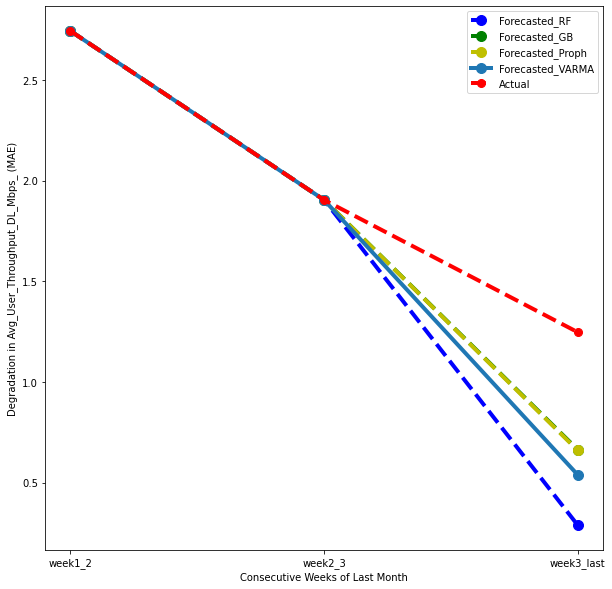

In [631]:
i = 0
tower = '4GSite1A'
forecast_prophet = FUT_ALL[i]['future_values'][1:]['yhat']
valid = Towers_4G_preprocessed[i].loc["2021-08-25":]['Avg_User_Throughput_DL_Mbps']
forecast_VARMAX = Results_VARMAX[tower].get_prediction(start ='2021-08-24', end ='2021-08-31')
forecast_Thp_DL_VARMAX = forecast_VARMAX.predicted_mean["Avg_User_Throughput_DL_Mbps"]
_, pred_4G_RF = Validate_Model_New(RF_multiout_4G, Towers_4G_Regression[tower]['X_valid'].reset_index().drop("Day", axis =1), Towers_4G_Regression[tower]['Y_valid'], show_plot = False)
_, pred_4G_GB = Validate_Model_New(GB_multiout_4G, Towers_4G_Regression[tower]['X_valid'].reset_index().drop("Day", axis =1), Towers_4G_Regression[tower]['Y_valid'], show_plot = False)



    
_ = Multiple_degr_eval(pred_4G_RF, pred_4G_GB, forecast_prophet,
                   forecast_Thp_DL_VARMAX[1:],
                   Towers_4G_preprocessed[i][TARGET_VARIABLES_4G].loc[pred_4G_RF.index],
                   Towers_4G_preprocessed[i][TARGET_VARIABLES_4G].loc["2021-08-01":],
                   "Avg_User_Throughput_DL_Mbps")

In [632]:

plot_all(pred_4G_RF, pred_4G_GB, forecast_prophet, forecast_Thp_DL_VARMAX[1:], valid, "Avg_User_Throughput_DL_Mbps")


## LSTM Neural Network


In [372]:
def split_sequences(tower, n_steps):
    """ 
    Returns training data per tower for LSTM network
    
            Parameters:
                    tower: input tower to split 
                    n_steps: number of input steps to gather per training record

                    
                    
            Returns:
                    X: gathered training features
                    Y: training variables
    """
    
    X, y = list(), list()
    for i in range(len(tower)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if  beyond the dataset
        if end_ix > len(tower)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = tower[i:end_ix, :], tower[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [604]:

def prepare_LSTM_data(towers_preprocessed, Cell_4G = True):
    """ 
    Returns merged training data for all towers for LSTM network
    
            Parameters:
                    towers_preprocessed: all towers to merge
                    Cell_4G: boolean to check tower type

                    
                    
            Returns:
                    X_Train_LSTM: concatentaed training features
                    Y_Train_LSTM: training targets 
                    X_Valid_LSTM: validation features
                    Y_Valid_LSTM:: validation targets
    """
    
    X_Train_LSTM = []
    Y_Train_LSTM = []
    X_Valid_LSTM = {}
    Y_Valid_LSTM = {}

    for tower in Towers_4G_preprocessed:
        
        if Cell_4G:
            #split each tower
            tower_name = tower["Cell Names"][0]
            X, Y = split_sequences(np.asarray(tower[tower.columns].drop("Cell Names", axis=1)), 7)
        else:
            tower_name = tower["Cell Name"][0]
            X, Y = split_sequences(np.asarray(tower[tower.columns].drop("Cell Name", axis=1)), 7)
        split_point = X.shape[0]-7 
        # append all towers in one list
        X_Train_LSTM.append(X[0:split_point]) 
        Y_Train_LSTM.append(Y[0:split_point])
        X_Valid_LSTM[tower_name] = X[split_point:]
        Y_Valid_LSTM[tower_name] = Y[split_point:]
    X_Train_LSTM = np.asarray(X_Train_LSTM).reshape(-1, X.shape[1],X.shape[2])
    Y_Train_LSTM = np.asarray(Y_Train_LSTM).reshape(-1, X.shape[2])    
    return X_Train_LSTM, Y_Train_LSTM, X_Valid_LSTM, Y_Valid_LSTM
    
X_Train_LSTM, Y_Train_LSTM, X_Valid_LSTM, Y_Valid_LSTM = prepare_LSTM_data(Towers_4G_preprocessed, Cell_4G = True)

In [609]:

def LSTM_training( X_train, Y_train, units =64, loss = 'mse', lr = 1e-3, epochs = 60, batch_size=20, validation_split =0.1):
    """ 
    Returnsa trained LSTM model
    
            Parameters:
                    X_train: training data features
                    Y_train: training targets
                    units: # of LSTM units
                    loss: loss metric
                    lr: learning rate
                    epochs: # of epochs for training
                    batch_size: training batch size
                    validation_split: percentage of data to use for validation

                    
                    
            Returns:
                    model: fitted LSTM model
    """
    model = Sequential()
    model.add(layers.LSTM(units,activation='relu',input_shape=(7, 13), return_sequences=True))
    model.add(layers.Dropout(0.2))

    #model.add(layers.LSTM(20, activation='relu', return_sequences=True))
    model.add(layers.LSTM(units//2, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(13))
    model.compile(loss=loss, optimizer= tf.keras.optimizers.Adam(learning_rate=lr))
    history = model.fit(X_Train_LSTM,
                        Y_Train_LSTM,
                        epochs=epochs, batch_size=batch_size,
                        validation_split=validation_split,
                        verbose=2, shuffle=True)
    return model


In [618]:
#history = model.fit(np.asarray(X_Train_LSTM).reshape(-1,7,13),np.asarray(Y_Train_LSTM).reshape(-1,13), epochs=80, batch_size=20, validation_split=0.1, verbose=2, shuffle=True)
model = LSTM_training( X_Train_LSTM, Y_Train_LSTM, units =64, loss = 'mse', lr = 1e-3, epochs = 60, batch_size=20, validation_split =0.1)

Epoch 1/60
179/179 - 3s - loss: 415.2481 - val_loss: 3860.3818 - 3s/epoch - 15ms/step
Epoch 2/60
179/179 - 1s - loss: 133.5430 - val_loss: 3059.4844 - 753ms/epoch - 4ms/step
Epoch 3/60
179/179 - 1s - loss: 114.9829 - val_loss: 2443.2717 - 728ms/epoch - 4ms/step
Epoch 4/60
179/179 - 1s - loss: 103.9235 - val_loss: 2505.5371 - 701ms/epoch - 4ms/step
Epoch 5/60
179/179 - 1s - loss: 95.7886 - val_loss: 2114.9475 - 654ms/epoch - 4ms/step
Epoch 6/60
179/179 - 1s - loss: 95.6404 - val_loss: 1910.8141 - 828ms/epoch - 5ms/step
Epoch 7/60
179/179 - 1s - loss: 90.4760 - val_loss: 1803.7791 - 741ms/epoch - 4ms/step
Epoch 8/60
179/179 - 1s - loss: 86.6430 - val_loss: 2017.6342 - 899ms/epoch - 5ms/step
Epoch 9/60
179/179 - 1s - loss: 88.9350 - val_loss: 1938.5187 - 757ms/epoch - 4ms/step
Epoch 10/60
179/179 - 1s - loss: 85.6864 - val_loss: 2071.7920 - 717ms/epoch - 4ms/step
Epoch 11/60
179/179 - 1s - loss: 86.3789 - val_loss: 1883.5087 - 644ms/epoch - 4ms/step
Epoch 12/60
179/179 - 1s - loss: 83.451

In [627]:
def LSTM_forecast_df(X_valid, tower):
    """ 
    Returnsa forecasted dataframe for all variables
    
            Parameters:
                    X_valid: validation data
                    tower: tower used for validation

                    
                    
            Returns:
                    yhat_df: forecasted dataframe
    """
    yhat = model.predict(np.asarray(X_valid).reshape(-1,7,13))
    yhat_df = pd.DataFrame(yhat)
    yhat_df.columns = tower.columns
    yhat_df.index = tower.tail(7).index
    return yhat_df



In [628]:
dates = Towers_4G_preprocessed[1][TARGET_VARIABLES_4G].tail(7).index
LSTM_forecast = LSTM_forecast_df(X_Valid_LSTM['4GSite1A'], Towers_4G_preprocessed[0].drop("Cell Names", axis=1))
Y_valid = pd.DataFrame(Y_Valid_LSTM['4GSite1A'], columns= Towers_4G_preprocessed[1].drop("Cell Names", axis=1).columns, index =dates) 
plot_forecast(dates,Y_valid, LSTM_forecast, "Avg_User_Throughput_DL_Mbps" )